<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты-и-загрузка-датафрейма" data-toc-modified-id="Импорты-и-загрузка-датафрейма-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты и загрузка датафрейма</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков." data-toc-modified-id="Подготовка-признаков.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков.</a></span><ul class="toc-item"><li><span><a href="#Подготовка-обучающей-и-тестовой-выборок" data-toc-modified-id="Подготовка-обучающей-и-тестовой-выборок-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Подготовка обучающей и тестовой выборок</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Условие: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



## Подготовка

### Импорты и загрузка датафрейма

In [1]:
!pip install -q catboost
!pip install -q lightgbm

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import Pool, CatBoostRegressor
from numpy.random import RandomState
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Сделаем настройки

# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Сбросим ограничение на число столбцов
pd.set_option('display.max_columns', None)

# Сбросим ограничение на число строк
pd.set_option('display.max_rows', None)

# Не показываем предупреждения
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Зададим константу для генератора псевдослучайных чисел
RANDOM_STATE = 42

# Зададим значение для генератора псевдослучайных чисел
np.random.seed(RANDOM_STATE)

In [3]:
# сразу сделаем индексом колонку datetime и приведем к формату даты
try:
    df = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нам предоставлены данные за период от 1 марта 2018 года до 31 августа 2018 года включительно. Всего 26496 случаев. 

In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
# Посмотрим общую информацию
df.describe()

,num_orders
count,"26,496.00"
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


Проверим в хронологическом ли порядке расположены дата и время.

In [7]:
df.index.is_monotonic 

True

Проверим на повторы.

In [8]:
df.index.is_unique

True

Выполним ресемплирование по одному часу. 

In [9]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
df.describe()

,num_orders
count,"4,416.00"
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


Количество случаев снизилось с 26.5 тысяч, до 4.5 тысяч.

## Анализ

Посмотрим частотное распределение количества заказов в час.

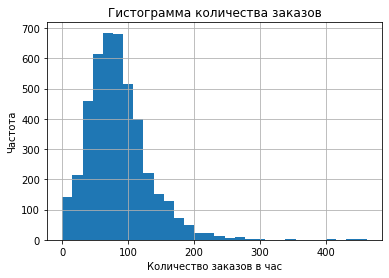

In [11]:
df.hist(bins=30)
plt.title('Гистограмма количества заказов')
plt.xlabel('Количество заказов в час')
plt.ylabel('Частота');

Распределение имеет нормальную форму, имется длинный тонкий хвост от 200 до 460 заказов в час. Посмотрим на эти случаи от 250.

In [12]:
df[df['num_orders'] > 250].sort_values(by='num_orders')

,num_orders
datetime,
2018-07-19 10:00:00,251
2018-04-24 00:00:00,253
2018-08-30 16:00:00,254
2018-08-18 02:00:00,254
2018-08-27 00:00:00,263
2018-08-29 23:00:00,265
2018-08-26 03:00:00,267
2018-08-31 04:00:00,268
2018-08-20 01:00:00,272


Большая часть пикового количества заказов приходится на конец предоставленного периода, визуально выделяется ночное время и есть несколько случаев на 16-17 часов 30 августа. Посмотрим в какие часы и дни недели происходит самое большое количество заказов.

In [13]:
df['num_orders'].sort_values(ascending=False)[:200].index.hour.value_counts()[:10]

0     45
2     24
1     21
16    17
23    14
3     14
4     13
17    11
22    11
9      7
Name: datetime, dtype: int64

Топ-3 - полночь и первые несколько часов после полуночи. 

Посмотрим среднее количество заказов в час по дням недели по всему датасету. 

In [14]:
# копируем датафрейм в отдельную переменную
data = df.copy()

# создадим новую колонку с днями недели, прибавим единицу, чтобы нумерация была от 1, а не от нуля
data['day_of_week'] = data.index.dayofweek + 1

data.head()

,num_orders,day_of_week
datetime,,
2018-03-01 00:00:00,124,4
2018-03-01 01:00:00,85,4
2018-03-01 02:00:00,71,4
2018-03-01 03:00:00,66,4
2018-03-01 04:00:00,43,4


Посмотрим среднее количество заказов в час по дням недели.

In [15]:
(
    data.groupby('day_of_week')
        .mean().sort_index()
        .sort_values(by=['num_orders'], ascending=False)
)

,num_orders
day_of_week,
5,91.14
1,90.25
4,85.66
6,83.85
3,83.75
7,78.99
2,77.01


Топ 3 - пятница, понедельник и четверг. В целом разброс не большой. 

Выведем график количества заказов. Чтобы снизить шум, дополнительно выведем скользящую среднюю за 24 часа.

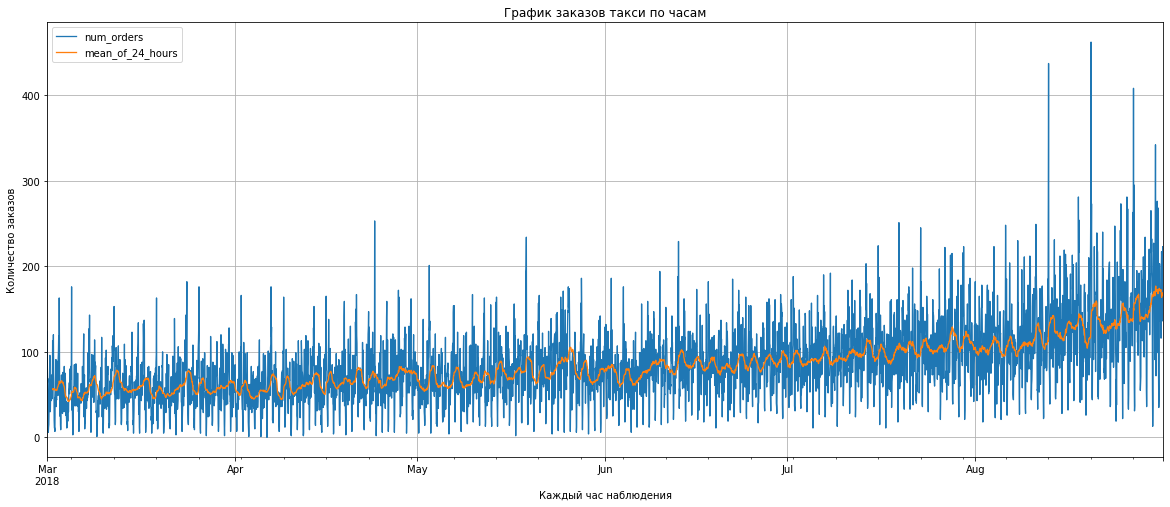

In [16]:
# удалим колонку с днями недели, для графика она нам не нужна
data.drop('day_of_week', axis=1, inplace=True)

# добавим новвую колонку со скользящим средним за 24 часа
data['mean_of_24_hours'] = data['num_orders'].rolling(24).mean()
data.plot(figsize=(20, 8), linewidth=1.3)
plt.title('График заказов такси по часам')
plt.xlabel('Каждый час наблюдения')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Мы видим, что с каждым месяцем заказов в час становиться больше, особенно выделяется август, кажется восходящий тренд ускорился. А судя по отсутствию каких либо значимых колебаний на майских праздниках - данные были собраны не в России.  

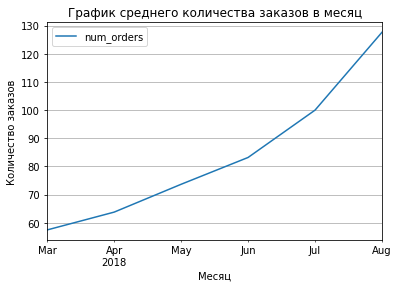

In [17]:
# посмотрим помесячный тренд количества заказов в час
df.resample('1M').mean().plot()
plt.title('График среднего количества заказов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid();

Да, с каждым месяцем среднее количество заказов в час становится больше. 

In [18]:
print('Среднее количество заказов в час в августе увеличилось в '
f'{np.array(df[df.index.month == 8].mean() / df[df.index.month == 4].mean())[0]:.1f} раза относительно марта')

Среднее количество заказов в час в августе увеличилось в 2.0 раза относительно марта


Посмотрим на тренды и сезонность.

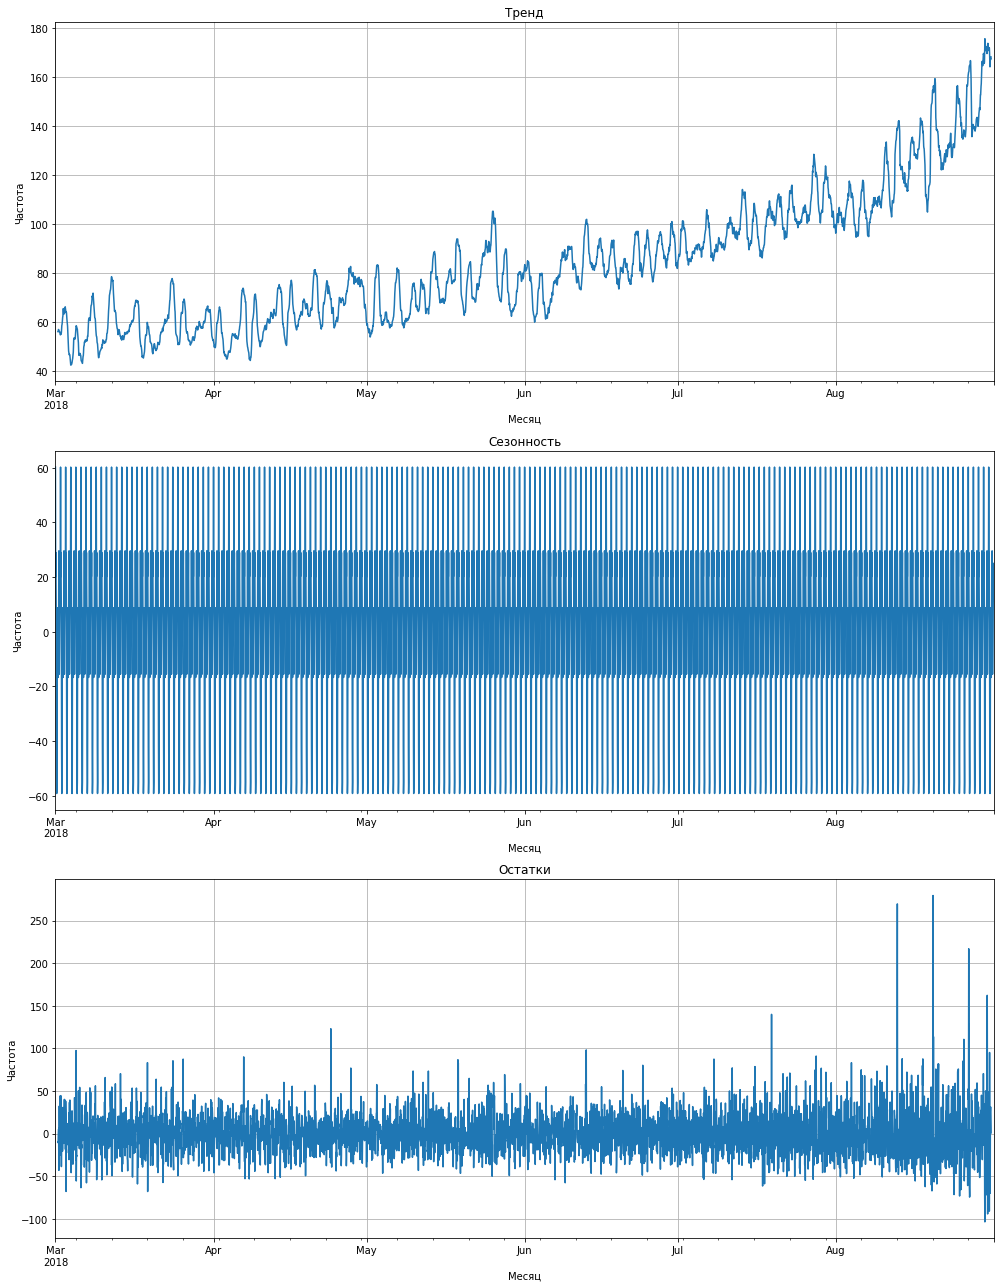

In [19]:
# создадим объект структуры DecomposeResult у которого будут рассчитаны нужные нам атрибуты
decomposed = seasonal_decompose(df)

plt.figure(figsize=(14, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.grid()

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()

Линия тренда восходящая с ускорением сначала с наступлением лета, потом в августе, что обьяснимо, так как летом чаще берут отпуска и, соответственно, трафик от аэропорта выше. А в августе в связи со скорым началом нового учебного года, возможно в дополнение к отпускникам, добавляются и возвращающеся с каникул. \
Так как у нас данные менее, чем за один год, сезонность имеет небольшой период, рассмотрим недельную сезонность. 

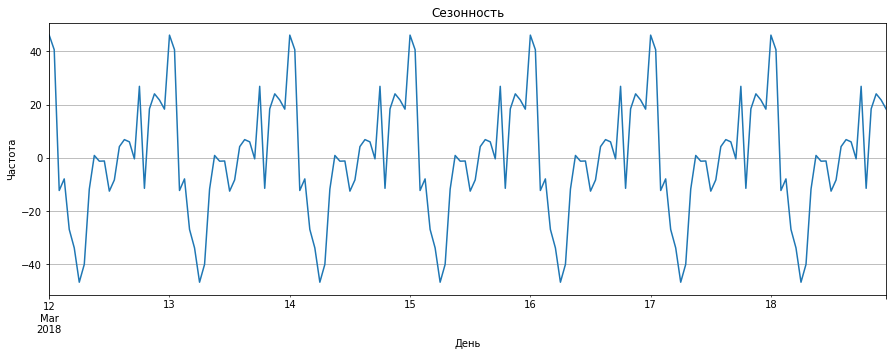

In [20]:
decomposed = seasonal_decompose(df['2018-03-12':'2018-03-18'])

plt.figure(figsize=(15, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('День')
plt.grid()
plt.ylabel('Частота');

Масштаб все еще слишком маленький. Укрупним - возьмом период в два дня.

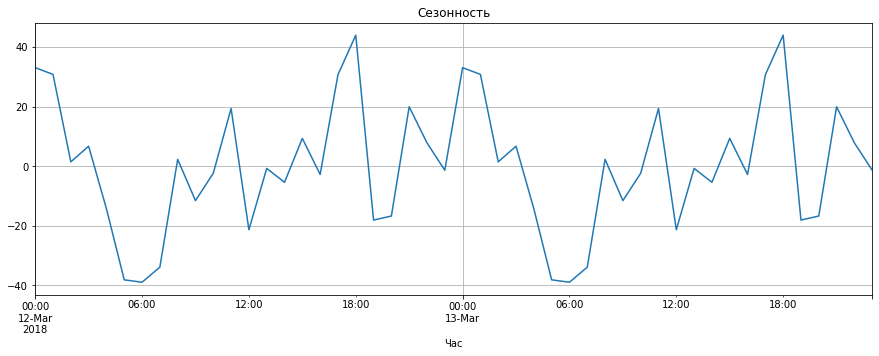

In [21]:
decomposed = seasonal_decompose(df['2018-03-12':'2018-03-13'])

plt.figure(figsize=(15, 5))
decomposed.seasonal.plot()
plt.title('Сезонность')
plt.xlabel('Час')
plt.grid()
# plt.ylabel('Частота');

Мы видим, что минимум заказов приходится на период с 5 до 7 утра, максимум наблюдается в 18 часов и в первые два часа после полуночи. \
Посмотрим меняется ли сезонность месяц от месяца, возьмем те же дни недели в августе.

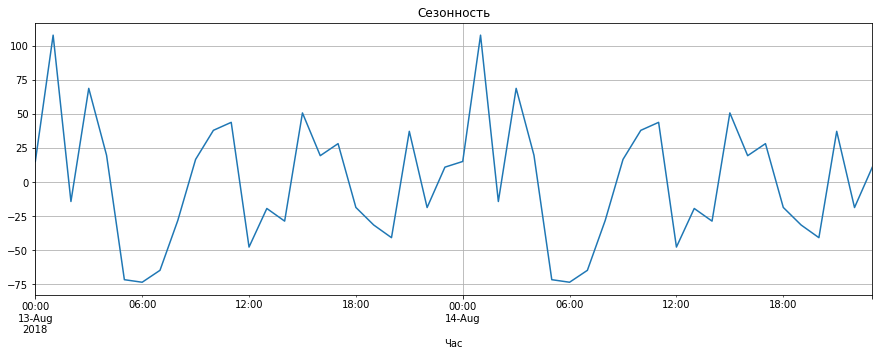

In [22]:
decomposed = seasonal_decompose(df['2018-08-13':'2018-08-14'])

plt.figure(figsize=(15, 5))
decomposed.seasonal.plot()
plt.title('Сезонность')
plt.xlabel('Час')
plt.grid()
# plt.ylabel('Частота');

График немного другой. Минимум все также приходится на утренние часы с пяти до семи утра, максимумами стали периоды с часу до двух ночи и с трех до четырех утра.

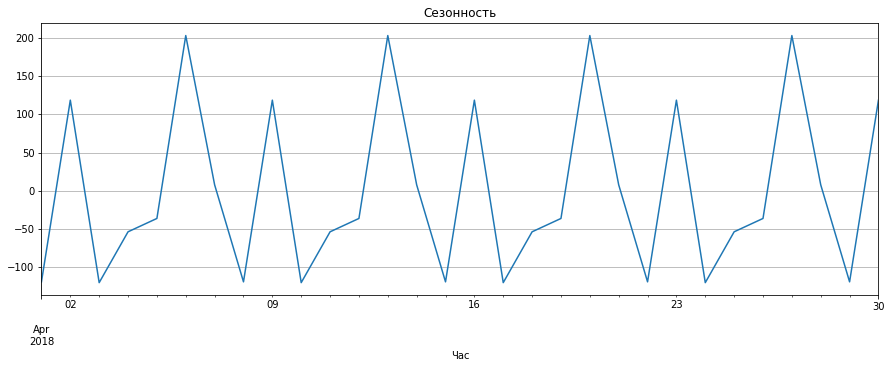

In [23]:
decomposed = seasonal_decompose(df.resample('1D').sum()['2018-04-01':'2018-04-30'])

plt.figure(figsize=(15, 5))
decomposed.seasonal.plot()
plt.title('Сезонность')
plt.xlabel('Час')
plt.grid()
# plt.ylabel('Частота');

### Вывод

Мы провели анализ предоставленных нам данных и выяснили, что:
1. С каждым месяцем среднее количество заказов в час, относительно марта, повышается, среднее количество заказов в час в августе увеличилось в два раза. 
2. Больше заказов в час в пятницу, понедельник и четверг.
3. Количество заказов в час начало быстрее увеличиваться с началом лета, что не удивительно, так как лето - начало отпусков. Второе увеличение скорости прироста количества заказов в час наблюдается примерно с 18 авгуса, это объясняется возвращением к началу учебного года школьников и студентов. Интересно было бы увидеть как меняется график в сентябре. 
4. Сезонность имеет дневной период, меняется месяц от месяца. В марте минимум заказов приходится на период с 5 до 7 утра, максимум наблюдается в 18 часов и в первые два часа после полуночи, в августе минимум идеинтичен, максимум же приходится на периоды с часу до двух ночи и с трех до четырех утра.

## Обучение

Так как целевой признак у нас количественный - перед нам стоит задача регрессии для временных рядов. \
Обучать мы будем три модели - Линейную регрессию, CatBoostRegressor и LGBMRegressor.

Сначала подготовим датасет. Так как таргет у нас количество заказов в день, добавим признаки, по которым модель сможет сможет предсказать значение в этой колонке. \
Добавим следующие колонки:
1. Час
2. День недели.
3. Месяц.
4. Скользящее среднее за предыдущие 24 часа. 
5. Последние 23 отстающих значения.

Год не будем добавлять, потому что он один для всех случаев. Скользящее среднее задает общее направление тренда, поэтому возьмем 24 часовой интервал.

Далее мы подготовим выборки для всех трех моделей:

1. Разделим на обучающие и тестовые выборки таргета и признаков.
2. Масштабируем числовые признаки для обучения модели линейной регрессии.

### Подготовка признаков.

In [24]:
def get_data(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    data['roll_mean_of_24_hour'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    for hour in range(1, max_lag):
        data[f'lag_{hour}'] = data['num_orders'].shift(hour)
    
    return data


data = get_data(df, 24, 24)
data.head(20)

,num_orders,hour,day_of_week,roll_mean_of_24_hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,NaN,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,NaN,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,NaN,43.00,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,NaN,6.00,43.00,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,3,NaN,12.00,6.00,43.00,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,3,NaN,15.00,12.00,6.00,43.00,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


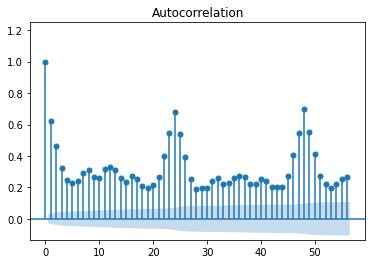

In [25]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=56, auto_ylims=True)
plt.show()

In [26]:
# удалим случаи с пропусками
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_orders            4392 non-null   int64  
 1   hour                  4392 non-null   int64  
 2   day_of_week           4392 non-null   int64  
 3   roll_mean_of_24_hour  4392 non-null   float64
 4   lag_1                 4392 non-null   float64
 5   lag_2                 4392 non-null   float64
 6   lag_3                 4392 non-null   float64
 7   lag_4                 4392 non-null   float64
 8   lag_5                 4392 non-null   float64
 9   lag_6                 4392 non-null   float64
 10  lag_7                 4392 non-null   float64
 11  lag_8                 4392 non-null   float64
 12  lag_9                 4392 non-null   float64
 13  lag_10                4392 non-null   float64
 14  lag_11                4392 n

#### Подготовка обучающей и тестовой выборок

Данных у нас немного, поэтому сделаем тестовую выборку в размере 10% от общего датасета. Валидационную формировать не будем.

In [27]:
# проставим shuffle=False, чтобы модель не обучалась на данных из будущего
target_train,  target_test, features_train, features_test = train_test_split(
    data['num_orders'], data.drop('num_orders', axis=1), shuffle=False, test_size=0.1
)

print(f'Размер обучающей выборки признаков - {features_train.shape}.')
print(f'Размер тестовой выборки признаков - {features_test.shape}.')

# проверим также, что данные расположены в хронологическом порядке
features_train.index.is_monotonic, features_test.index.is_monotonic

Размер обучающей выборки признаков - (3952, 26).
Размер тестовой выборки признаков - (440, 26).


(True, True)

### Обучение моделей

#### Линейная регрессия

Обучим модель и измерим RMSE.

In [29]:
%%time
model_lreg = LinearRegression()
model_lreg.fit(features_train, target_train)

tscv = TimeSeriesSplit(n_splits=3)

cvs_lreg = cross_val_score(
    model_lreg,
    features_train,
    target_train,
    cv=tscv,
    scoring='neg_mean_squared_error')

rmse_lreg = (-cvs_lreg.mean())**0.5
f'RMSE для модели линейной регрессии: {rmse_lreg:.2f}'

CPU times: user 153 ms, sys: 156 ms, total: 310 ms
Wall time: 299 ms


'RMSE для модели линейной регрессии: 27.96'

#### LGBMRegressor

Так как мы прогнозируем временные ряды обычная кросс-валидация нам не подходит, потому что она тасует данные из-за чего валидационные данные мугут идти до обучающих. \
Воспользуемся TimeSeriesSplit из scikit-learn - это метод кросс-валидации, специально разработанный для данных временных рядов. Он разбивает данные на несколько обучающих и тестовых наборов, где каждый тестовый набор представляет собой непрерывную последовательность точек данных. Доплним параметром n_splits=3 который задает количество создаваемых разбиений. По дефолту разбиений пять, но так как у нас немного данных, снизим этот параметр до трех.

In [30]:
%%time

tscv = TimeSeriesSplit(n_splits=3)

model = LGBMRegressor(num_leaves=50)

param_grid = {'max_depth': [2, 5, 10, 20, 25],
              'n_estimators': [20, 25, 50, 100]}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=tscv,
    n_jobs = -1,
    scoring = 'neg_mean_squared_error'
)

grid_search.fit(features_train, target_train)

CPU times: user 35.5 s, sys: 225 ms, total: 35.7 s
Wall time: 36.1 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(num_leaves=50), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 20, 25],
                         'n_estimators': [20, 25, 50, 100]},
             scoring='neg_mean_squared_error')

In [31]:
f'Наилучшие значения параметров: {grid_search.best_params_}'

"Наилучшие значения параметров: {'max_depth': 5, 'n_estimators': 100}"

In [32]:
rmse_light = np.sqrt(-grid_search.best_score_)
f'Наилучшая оценка модели: {rmse_light:.2f}'

'Наилучшая оценка модели: 26.95'

**Обучим модель и измерим RMSE.**

#### CatBoostRegressor

Подберем лучшие параметры модели c помощью GridSearchCV.

In [34]:
%%time

# не указываем num_leaves, ограничение бибиотеки
model = CatBoostRegressor()

# у CatBoostRegressor ограничение на глубину - 16,
# поэтому изменим список вариантов
param_grid = {'max_depth': [2, 5, 7, 10],
              'n_estimators': [25, 50, 100]}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=tscv,
    n_jobs = -1,
    scoring = 'neg_mean_squared_error'
)

grid_search.fit(features_train, target_train, verbose=0)

CPU times: user 25.9 s, sys: 199 ms, total: 26.1 s
Wall time: 49.1 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f8f4818e100>,
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [25, 50, 100]},
             scoring='neg_mean_squared_error')

In [35]:
f'Наилучшие значения параметров: {grid_search.best_params_}'

"Наилучшие значения параметров: {'max_depth': 5, 'n_estimators': 100}"

In [36]:
rmse_cat = np.sqrt(-grid_search.best_score_)
f'Наилучшая оценка модели: {rmse_cat:.2f}'

'Наилучшая оценка модели: 27.20'

### Вывод

Мы подготовили выборки, обучили три модели и сделали предсказания. \
Модели показали следующие результаты метрики RMSE:

In [38]:
table = pd.DataFrame(index = ['Линейная регрессия', 'LGBMRegressor', 'CatBoostRegressor'],
                     columns=['качество предсказания'],
                     data=[[rmse_lreg],
                           [rmse_light],
                           [rmse_cat]])
table

,качество предсказания
Линейная регрессия,"[-620.499929541443, -682.6257403421558, -1042...."
LGBMRegressor,26.95
CatBoostRegressor,27.20


RMSE так низко, потому что предсказания мы делали на тестовой выборке. Данных довольно мало, поэтомы мы решили повысить качество обучения и обойтись без валидационной выборки, выделив этот объем данных для обучения модели. \
Лучшие результаты показала модель LGBMRegressor, ее мы и будем проверять на этапе тестирования.

## Тестирование

In [31]:
predict = grid_search.predict(features_test)

rmse_light = mean_squared_error(target_test, predict, squared=False)

f'RMSE модели LGBMRegressor на тестовой выборке: {rmse_light:.2f}'

'RMSE модели LGBMRegressor на тестовой выборке: 41.03'

RMSE довольно высоко, это связано с тем, что в конце августа линия тренда меняется - ускоряет свой рост, модель же такое развитие событий не предполагает, так как в обучающих данных не было подобных скачков спроса.  

Сравним качество предсказания нашей модели с предсказаниями модели, которая всегда предсказывает предыдущее значение. 

In [32]:
round(mean_squared_error(target_test.shift()[1:], target_test[1:], squared=False), 2)    

58.93

Модель, всегда предсказывающая количество заказов за предыдущий час, менее точна, чем обученная нами модель.

## Вывод

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам необходимо было обучить модель, значение метрики RMSE которой не превышало 48. 

Нам были предоставлены данные за период от 1 января до 31 августа 2018 года. 

В ходе работы мы:
- предобработали данные - ресемплировали их по 1 часу,
- проанализировали - выяснили, что линия тренда возврастающая, скороть роста меняется несколько раз в начале лета и в середине августа. Количество заказов в час в течении суток расперделено неравномерно, минимум заказов совершается в районе 5-6 утра, максимум - в первые часы после полуночи. Данное распределение непостоянно и немного меняется со временем. Больше всего заказов совершается по пятницам, меньше всего по вторникам.
- подготовили выборки и обучили три модели: Линейную регрессию, CatBoostRegressor и LGBMRegressor, они показали следующие результаты:

In [ ]:
table

Лучше всего себя показала модель LGBMRegressor, на этапе тестирования она показала результат метрики RMSE - 41.64. Качество предсказания значительно хуже, чем на тестовых данных, так как линия тренда довольно резко меняется в августе (данное измменение вошло в тестовую выборку) и наша модель не обучена таким изменениям.

Качество предсказания модели можно повысить, обучив модель на данных за прошлый год. Мы уверены, что подобное увеличение спроса - сезонное изменение, повторяется ежегодно, поэтому обучение на данных за прошлый год поможет значительно повысить точность прогноза. 

Дополнительно мы сравнили предсказания нашей модели и модели, которая всегда делает предсказание количеством заказов за предыдущий час. Обученая нами модель имеет метрику RMSE 41.64, а тестовая - 58.93, то есть наша модель более точна. 